In [1]:
import os
work_dir = 'pbmc_tutorial'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/cellar/users/aklie/tmp/'

In [2]:
fragments_dict = {'10x_pbmc': os.path.join(work_dir, 'data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz')}

In [3]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [4]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [8]:
fragments = pd.read_csv(fragments_dict["10x_pbmc"], sep="\t", header=None, comment="#")

In [11]:
cell_data

,n_genes,doublet_score,predicted_doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,ingest_celltype_label,leiden_res_0.8,celltype,sample_id
AAACAGCCAAATATCC-1,2272,0.006036,False,2271,4746.0,369.0,7.774969,NK cells,9,NK_cells,10x_pbmc
AAACAGCCAGGAACTG-1,3254,0.021077,False,3253,7760.0,693.0,8.930412,CD14+ Monocytes,5,CD14+_Monocytes,10x_pbmc
AAACAGCCAGGCTTCG-1,1798,0.042017,False,1793,3661.0,409.0,11.171811,CD14+ Monocytes,3,CD14+_Monocytes,10x_pbmc
AAACCAACACCTGCTC-1,1145,0.024421,False,1142,2159.0,271.0,12.552108,B cells,7,B_cells_1,10x_pbmc
AAACCAACAGATTCAT-1,1495,0.013229,False,1494,2909.0,293.0,10.072189,NK cells,6,CD8_T_cells,10x_pbmc
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATCCGTAA-1,1346,0.007582,False,1343,2560.0,432.0,16.875000,B cells,7,B_cells_1,10x_pbmc
TTTGTGGCATTAGCCA-1,972,0.028264,False,969,1746.0,191.0,10.939290,CD4 T cells,0,CD4_T_cells,10x_pbmc
TTTGTGGCATTGCGAC-1,2330,0.004622,False,2330,4772.0,316.0,6.621961,NK cells,9,NK_cells,10x_pbmc
TTTGTGTTCCGCCTAT-1,1057,0.068845,False,1056,1913.0,252.0,13.173027,CD4 T cells,0,CD4_T_cells,10x_pbmc


In [9]:
fragments

,0,1,2,3,4
0,chr1,10073,10209,TTTAGCAAGGTAGCTT-1,1
1,chr1,10079,10285,GCCTTTGGTTGGTTCT-1,1
2,chr1,10079,10333,AGCCGGTTCCGGAACC-1,1
3,chr1,10089,10560,TGATTAGTCTACCTGC-1,1
4,chr1,10090,10346,ATTGACTCAATCCTGA-1,1
...,...,...,...,...,...
44109949,KI270713.1,37465,37495,TCCAGGTCAAGGTCCT-1,2
44109950,KI270713.1,37469,37691,TTGGCTTGTGTGTGGT-1,1
44109951,KI270713.1,37655,37699,GCTTCGCGTGATTACG-1,1
44109952,KI270713.1,37656,37857,GGGTGAAGTCACAAAT-1,3


In [10]:
cell_data.index.isin(fragments[3]).sum()

2609

In [16]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 8,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = '-')

2023-01-02 12:34:58,546 cisTopic     INFO     Reading fragments from pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz


2023-01-02 12:36:00,603	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


(export_pseudobulk_ray pid=93288) 2023-01-02 12:36:14,848 cisTopic     INFO     Creating pseudobulk for B_cells_1
(export_pseudobulk_ray pid=93283) 2023-01-02 12:36:15,263 cisTopic     INFO     Creating pseudobulk for B_cells_2
(export_pseudobulk_ray pid=93280) 2023-01-02 12:36:15,589 cisTopic     INFO     Creating pseudobulk for CD14_Monocytes
(export_pseudobulk_ray pid=93286) 2023-01-02 12:36:16,124 cisTopic     INFO     Creating pseudobulk for CD4_T_cells
(export_pseudobulk_ray pid=93285) 2023-01-02 12:36:16,719 cisTopic     INFO     Creating pseudobulk for CD8_T_cells
(export_pseudobulk_ray pid=93281) 2023-01-02 12:36:17,636 cisTopic     INFO     Creating pseudobulk for Dendritic_cells
(export_pseudobulk_ray pid=93282) 2023-01-02 12:36:18,265 cisTopic     INFO     Creating pseudobulk for FCGR3A_Monocytes
(export_pseudobulk_ray pid=93287) 2023-01-02 12:36:19,080 cisTopic     INFO     Creating pseudobulk for NK_cells
(export_pseudobulk_ray pid=93283) 2023-01-02 12:36:26,577 cisTopic 

In [17]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [23]:
import pickle
bed_paths = pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='/cellar/users/aklie/opt/miniconda3/envs/scenicplus/bin/macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=8,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2023-01-02 12:50:30,038	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


(macs_call_peak_ray pid=98765) 2023-01-02 12:50:42,375 cisTopic     INFO     Calling peaks for FCGR3A_Monocytes with /cellar/users/aklie/opt/miniconda3/envs/scenicplus/bin/macs2 callpeak --treatment pbmc_tutorial/scATAC/consensus_peak_calling/pseudobulk_bed_files/FCGR3A_Monocytes.bed.gz --name FCGR3A_Monocytes  --outdir pbmc_tutorial/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=98766) 2023-01-02 12:50:42,383 cisTopic     INFO     Calling peaks for Dendritic_cells with /cellar/users/aklie/opt/miniconda3/envs/scenicplus/bin/macs2 callpeak --treatment pbmc_tutorial/scATAC/consensus_peak_calling/pseudobulk_bed_files/Dendritic_cells.bed.gz --name Dendritic_cells  --outdir pbmc_tutorial/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=987

In [24]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [27]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
path_to_blacklist= os.path.join(work_dir, 'hg38-blacklist.v2.bed')
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2023-01-02 12:56:07,726 cisTopic     INFO     Extending and merging peaks per class
2023-01-02 12:57:14,934 cisTopic     INFO     Normalizing peak scores
2023-01-02 12:57:15,215 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2023-01-02 12:58:33,936 cisTopic     INFO     Done!


In [30]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

In [34]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(work_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

/tmp/ipykernel_91218/2503884162.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


2023-01-02 13:04:05,843 cisTopic     INFO     Reading 10x_pbmc
2023-01-02 13:04:50,078 cisTopic     INFO     Computing barcode rank plot for 10x_pbmc
2023-01-02 13:04:50,079 cisTopic     INFO     Counting fragments
2023-01-02 13:04:53,835 cisTopic     INFO     Marking barcodes with more than 100
2023-01-02 13:04:53,886 cisTopic     INFO     Returning plot data
2023-01-02 13:04:53,889 cisTopic     INFO     Returning valid barcodes
2023-01-02 13:04:56,837 cisTopic     INFO     Computing duplicate rate plot for 10x_pbmc
2023-01-02 13:05:01,865 cisTopic     INFO     Return plot data
2023-01-02 13:05:02,061 cisTopic     INFO     Computing insert size distribution for 10x_pbmc
2023-01-02 13:05:02,062 cisTopic     INFO     Counting fragments
2023-01-02 13:05:03,161 cisTopic     INFO     Returning plot data
2023-01-02 13:05:22,832 cisTopic     INFO     Computing TSS profile for 10x_pbmc
2023-01-02 13:05:26,637 cisTopic     INFO     Formatting annnotation
2023-01-02 13:05:26,722 cisTopic     IN

/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in

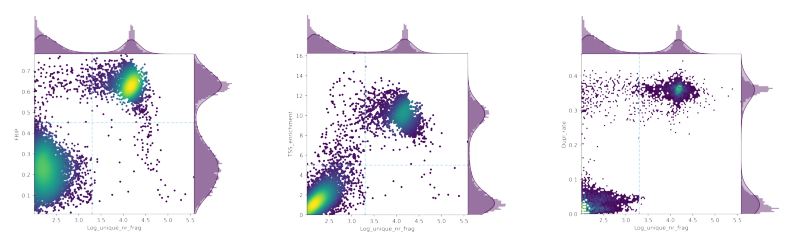

In [36]:
                         #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [37]:
bc_passing_filters = {'10x_pbmc':[]}
bc_passing_filters['10x_pbmc'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['10x_pbmc'])} barcodes passed QC stats")

2521 barcodes passed QC stats
